In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
url='/content/drive/MyDrive/Colab Notebooks/Data/dirty_cafe_sales.csv'
df=pd.read_csv(url)

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [ ]:
#dimension of the dataset
df.shape

(10000, 8)

In [ ]:
#find the information for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [ ]:
#determine statistical information on the dataset
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


### Description of categorical cols

In [ ]:
#calculate the frequency for the "Location" col
max_location=df['Location'].value_counts()
max_location

,count
Location,
Takeaway,3022
In-store,3017
ERROR,358
UNKNOWN,338


In [ ]:
#calculate the frequency for the "Payment Method" col
max_pay=df['Payment Method'].value_counts()
max_pay

,count
Payment Method,
Digital Wallet,2291
Credit Card,2273
Cash,2258
ERROR,306
UNKNOWN,293


In [ ]:
#calculate the frequency for the "Item" col
max_item=df['Item'].value_counts()
max_item

,count
Item,
Juice,1171
Coffee,1165
Salad,1148
Cake,1139
Sandwich,1131
Smoothie,1096
Cookie,1092
Tea,1089
UNKNOWN,344


## Determine the missing values

In [ ]:
#determine the number of missing values
missing_values=df.isna().sum().reset_index()
missing_values.rename(columns={'index':'col_name',0:'NaN'},inplace=True)
missing_values

,col_name,NaN
0,Transaction ID,0
1,Item,333
2,Quantity,138
3,Price Per Unit,179
4,Total Spent,173
5,Payment Method,2579
6,Location,3265
7,Transaction Date,159


### Categorical cols

The missing values are replaced with UNKNOWN. I don't want to modify the dataset using the most frequent value.

In [ ]:
cols=['Location','Payment Method','Item']
df[cols]=df[cols].replace([np.nan,'ERROR'],"UNKNOWN")

### Date col

I delete the rown with missing data

In [ ]:
#correct the date col
df['Transaction Date']=df['Transaction Date'].replace(["UNKNOWN",'ERROR'],np.nan)
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

In [ ]:
#drop the rows with missing values
df.dropna(subset=['Transaction Date'], inplace=True)

### Continuous attributes

In [ ]:
columns=['Quantity','Price Per Unit','Total Spent']
df[columns]=df[columns].replace(['UNKNOWN','ERROR'],np.nan)

In [ ]:
#converting necessary cols to float
for c in columns:
  df[c] = pd.to_numeric(df[c], errors='coerce')
  df[c] = df[c].astype(float)

In [ ]:
# Replace NaN values with the relation: 'Total Spent' = 'Quantity' * 'Price Per Unit'
df["Total Spent"] = df["Total Spent"].fillna(df["Quantity"] * df["Price Per Unit"])
df["Quantity"] = df["Quantity"].fillna(df["Total Spent"] / df["Price Per Unit"])
df["Price Per Unit"] = df["Price Per Unit"].fillna(df["Total Spent"] / df["Quantity"])

In [ ]:
#drop the rows with nan values
df.dropna(subset=['Quantity'], inplace=True)
df.dropna(subset=['Price Per Unit'], inplace=True)
df.dropna(subset=['Total Spent'], inplace=True)

In [ ]:
#determine the number of missing values
df.isna().sum()

,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


##Duplicates

In [ ]:
duplicates = df.duplicated()

# count the duplicates
num_duplicates = duplicates.sum()
print(f"Numero di righe duplicate: {num_duplicates}")

Numero di righe duplicate: 0


## Anomalies

In [ ]:
# IQR
Q1 = df['Total Spent'].quantile(0.25)
Q3 = df['Total Spent'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# outlier
outliers = df[(df['Total Spent'] < lower_bound) | (df['Total Spent'] > upper_bound)]
print(outliers)

     Transaction ID     Item  Quantity  Price Per Unit  Total Spent  \
10      TXN_2548360    Salad       5.0             5.0         25.0   
51      TXN_6342161    Salad       5.0             5.0         25.0   
52      TXN_8914892  UNKNOWN       5.0             5.0         25.0   
96      TXN_5220895    Salad       5.0             5.0         25.0   
100     TXN_9517146  UNKNOWN       5.0             5.0         25.0   
...             ...      ...       ...             ...          ...   
9791    TXN_1232346    Salad       5.0             5.0         25.0   
9805    TXN_9506076    Salad       5.0             5.0         25.0   
9879    TXN_6393305    Salad       5.0             5.0         25.0   
9908    TXN_8922585    Salad       5.0             5.0         25.0   
9971    TXN_6120851    Salad       5.0             5.0         25.0   

      Payment Method  Location Transaction Date  
10              Cash  Takeaway       2023-11-07  
51           UNKNOWN  Takeaway       2023-01-08

### Detecting unusual or erroneous values in categorical columns (e.g. typing errors or rare categories).

In [ ]:
threshold = 5  # minimum threshold
max_location=df['Location'].value_counts()
anomalies_loc = max_location[max_location < threshold]
print('Anomalies in the Location col: ',anomalies_loc)

Anomalies in the Location col:  Series([], Name: count, dtype: int64)


In [ ]:
max_pay=df['Payment Method'].value_counts()
anomalies_pay = max_pay[max_pay < threshold]
print('Anomalies in the Payment Method col: ',anomalies_pay)

Anomalies in the Payment Method col:  Series([], Name: count, dtype: int64)


In [ ]:
max_item=df['Item'].value_counts()
anomalies_item = max_item[max_item < threshold]
print('Anomalies in the Item col: ',anomalies_item)

Anomalies in the Item col:  Series([], Name: count, dtype: int64)


# Univariate analysis




In [ ]:
df.describe(include="all")

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,9485,9485,9485.000000,9485.000000,9485.000000,9485,9485,9485
unique,9485,9,NaN,NaN,NaN,4,3,NaN
top,TXN_1961373,Juice,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NaN
freq,1,1120,NaN,NaN,NaN,2997,3760,NaN
mean,NaN,NaN,3.022035,2.949236,8.923880,NaN,NaN,2023-07-01 23:58:10.690564096
min,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,2023-01-01 00:00:00
25%,NaN,NaN,2.000000,2.000000,4.000000,NaN,NaN,2023-04-01 00:00:00
50%,NaN,NaN,3.000000,3.000000,8.000000,NaN,NaN,2023-07-02 00:00:00
75%,NaN,NaN,4.000000,4.000000,12.000000,NaN,NaN,2023-10-02 00:00:00
max,NaN,NaN,5.000000,5.000000,25.000000,NaN,NaN,2023-12-31 00:00:00


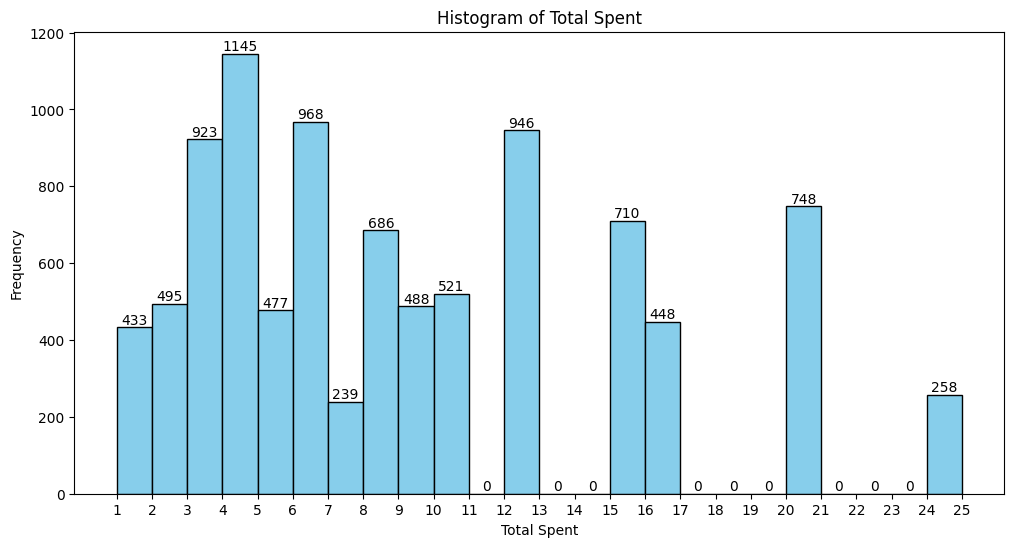

In [ ]:
plt.figure(figsize=(12, 6))

bins = np.linspace(min(df["Total Spent"]), max(df["Total Spent"]), 25)
n, bins_edges, patches = plt.hist(df['Total Spent'], bins=bins, color='skyblue', edgecolor='black')

# Aggiungere le etichette ai bin
for i in range(len(patches)):
    plt.text(
        # Posizionare l'etichetta al centro del bin
        x=(bins_edges[i] + bins_edges[i + 1]) / 2,
        y=n[i],  # Posizionare l'etichetta sopra la barra
        s=str(int(n[i])),  # Testo da mostrare (conteggio)
        ha='center',  # Allineare il testo orizzontalmente
        va='bottom',  # Allineare il testo verticalmente
        fontsize=10
    )

plt.xticks(ticks=bins)
plt.title('Histogram of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


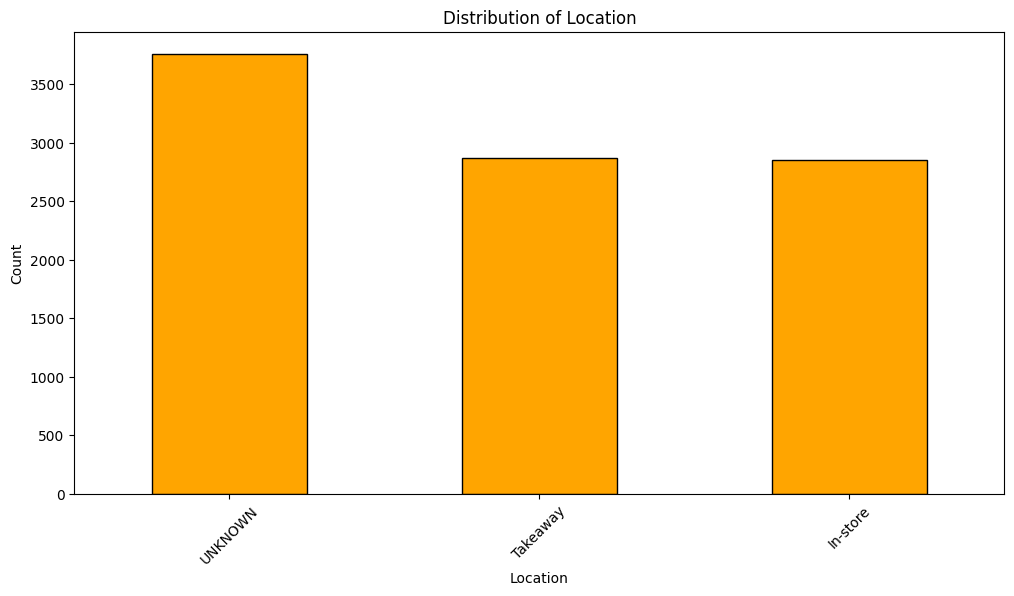

In [ ]:
# Bar chart per 'Location'
plt.figure(figsize=(12, 6))
max_location.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Distribution of Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

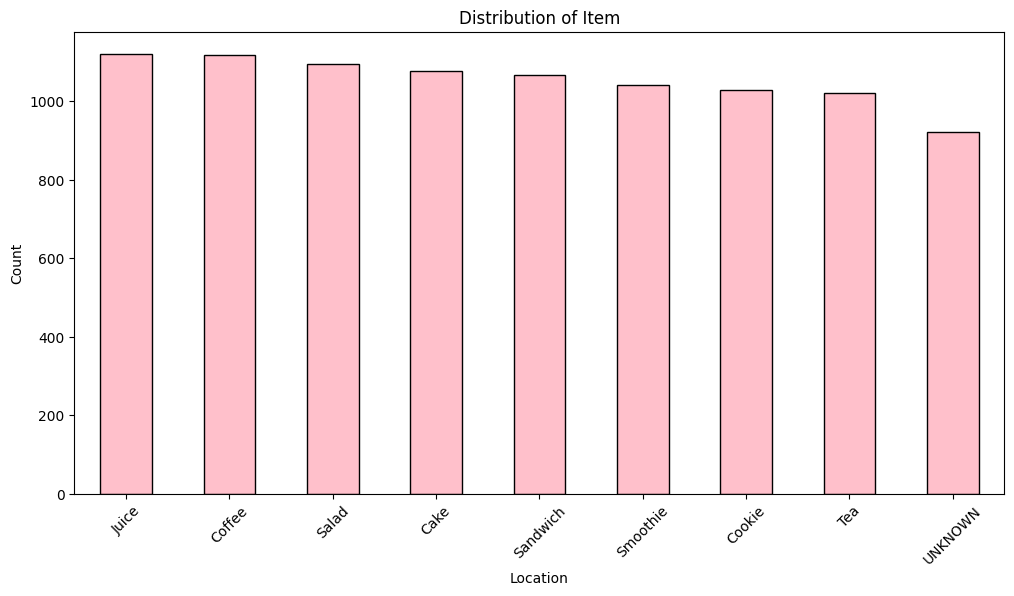

In [ ]:
# Bar chart per 'Item'
plt.figure(figsize=(12, 6))
max_item.plot(kind='bar', color='pink', edgecolor='black')
plt.title('Distribution of Item')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

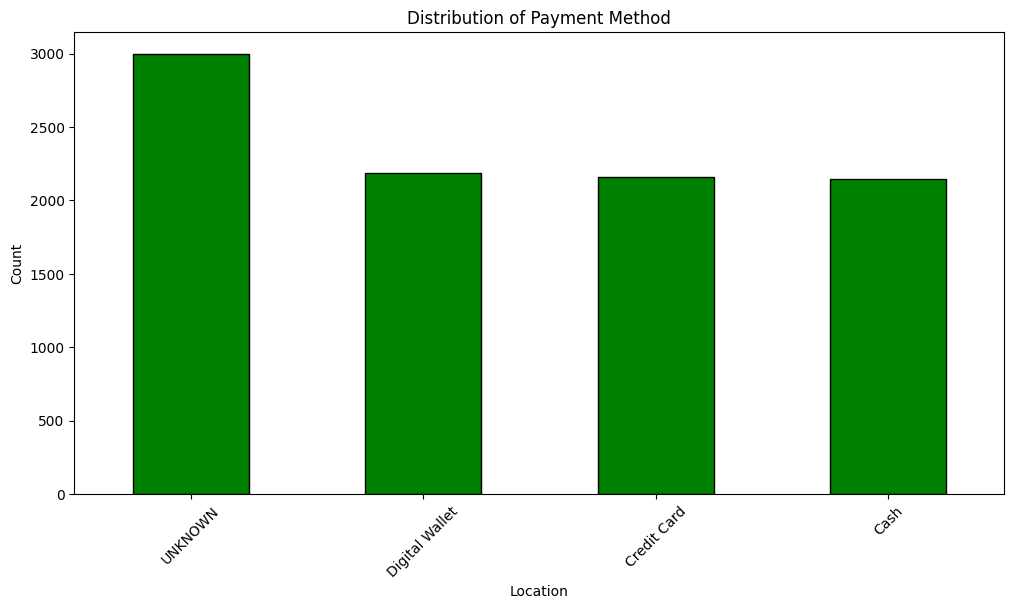

In [ ]:
# Bar chart per 'Payment Method'
plt.figure(figsize=(12, 6))
max_pay.plot(kind='bar', color='green', edgecolor='black')
plt.title('Distribution of Payment Method')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Bivariate analysis



In [ ]:
grouped_stats = df.groupby('Item')['Total Spent'].describe()
print(grouped_stats)

           count       mean       std  min   25%   50%   75%   max
Item                                                              
Cake      1077.0   9.105850  4.284485  3.0   6.0   9.0  12.0  15.0
Coffee    1116.0   6.093190  2.864708  2.0   4.0   6.0   8.0  10.0
Cookie    1028.0   2.981518  1.421304  1.0   2.0   3.0   4.0   5.0
Juice     1120.0   8.943750  4.180197  3.0   6.0   9.0  12.0  15.0
Salad     1095.0  15.109589  7.214198  5.0  10.0  15.0  20.0  25.0
Sandwich  1066.0  12.191370  5.715719  4.0   8.0  12.0  16.0  20.0
Smoothie  1042.0  12.222649  5.687706  4.0   8.0  12.0  16.0  20.0
Tea       1020.0   4.548529  2.127521  1.5   3.0   4.5   6.0   7.5
UNKNOWN    921.0   8.726927  5.876036  1.0   4.0   7.5  12.0  25.0


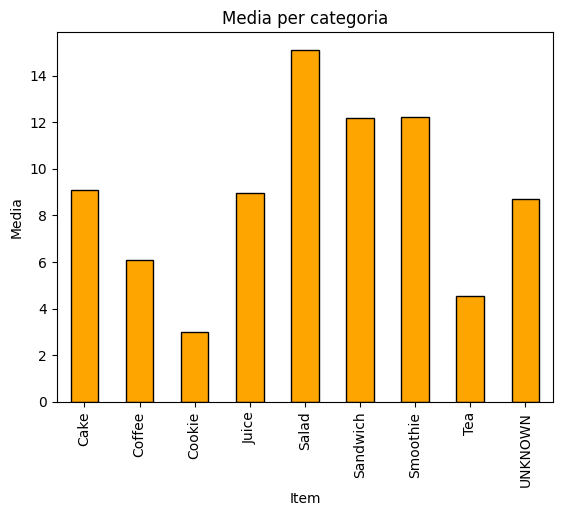

In [ ]:
grouped_means = df.groupby('Item')['Total Spent'].mean()
grouped_means.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Mean by Item')
plt.ylabel('Mean')
plt.show()

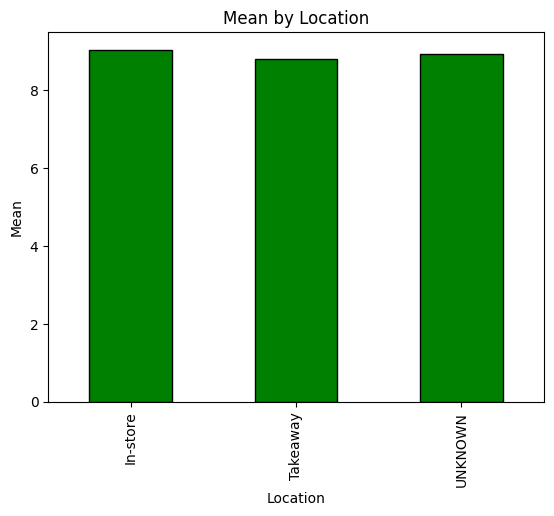

In [ ]:
loc_spent_mean = df.groupby('Location')['Total Spent'].mean()
loc_spent_mean.plot(kind='bar', color='green', edgecolor='black')
plt.title('Mean by Location')
plt.ylabel('Mean')
plt.show()

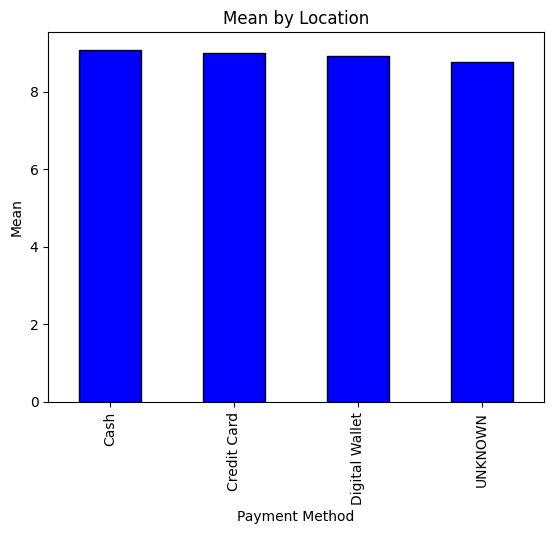

In [ ]:
pay_spent_mean = df.groupby('Payment Method')['Total Spent'].mean()
pay_spent_mean.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Mean by Location')
plt.ylabel('Mean')
plt.show()

Location  In-store  Takeaway  UNKNOWN
Item                                 
Cake           303       327      447
Coffee         304       337      475
Cookie         309       345      374
Juice          348       318      454
Salad          347       336      412
Sandwich       352       318      396
Smoothie       304       289      449
Tea            304       316      400
UNKNOWN        282       286      353


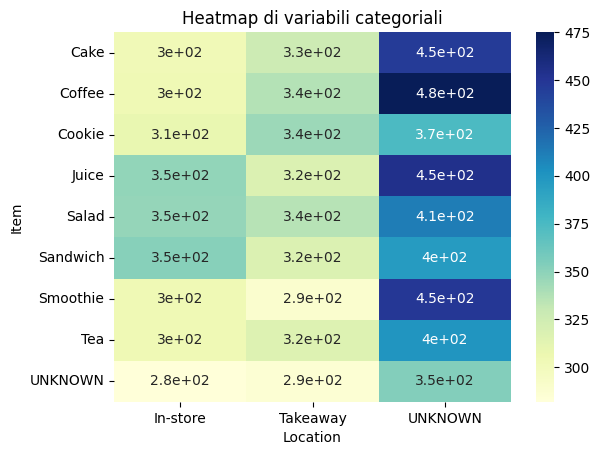

In [ ]:
contingency_table = pd.crosstab(df['Item'], df['Location'])
print(contingency_table)
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu')
plt.title('Heatmap Item vs Location')
plt.show()

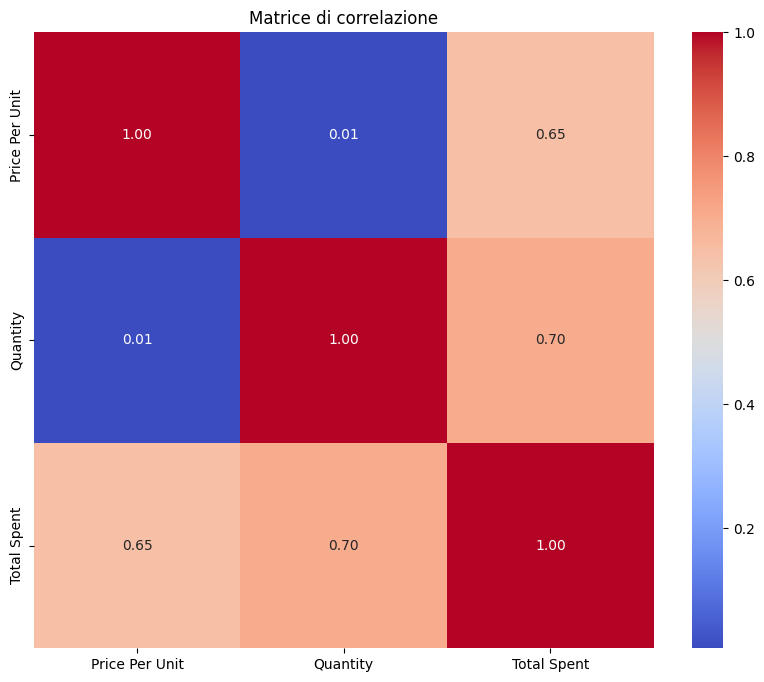

In [ ]:
# Correlation matrix
correlation_matrix = df[['Price Per Unit','Quantity','Total Spent']].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di correlazione')
plt.show()

### 'Transaction Date' analysis

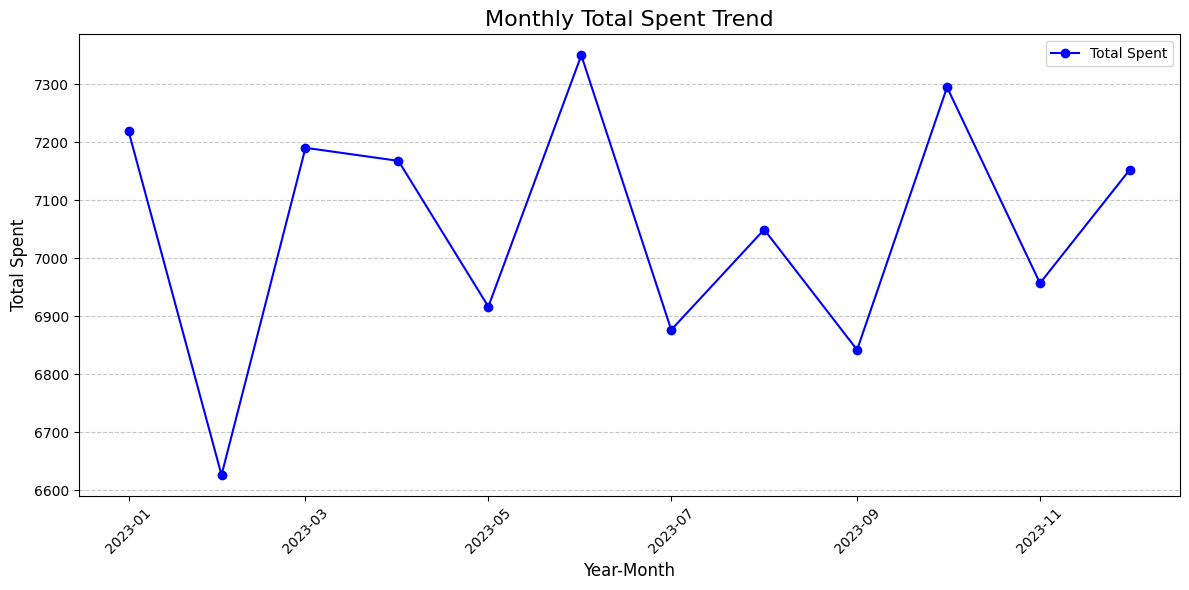

In [ ]:
# New column 'Year-Month'
df['Year-Month'] = df['Transaction Date'].dt.to_period('M')

monthly_spent = df.groupby('Year-Month')['Total Spent'].sum().reset_index()

# Conversion of 'Year-Month' col
monthly_spent['Year-Month'] = monthly_spent['Year-Month'].dt.to_timestamp()

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_spent['Year-Month'], monthly_spent['Total Spent'], marker='o', color='blue', label='Total Spent')

plt.title('Monthly Total Spent Trend', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Total Spent', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Ruotare le etichette sull'asse X per leggibilità
plt.legend()
plt.tight_layout()

plt.show()


Are there any seasonality in the products sold ?

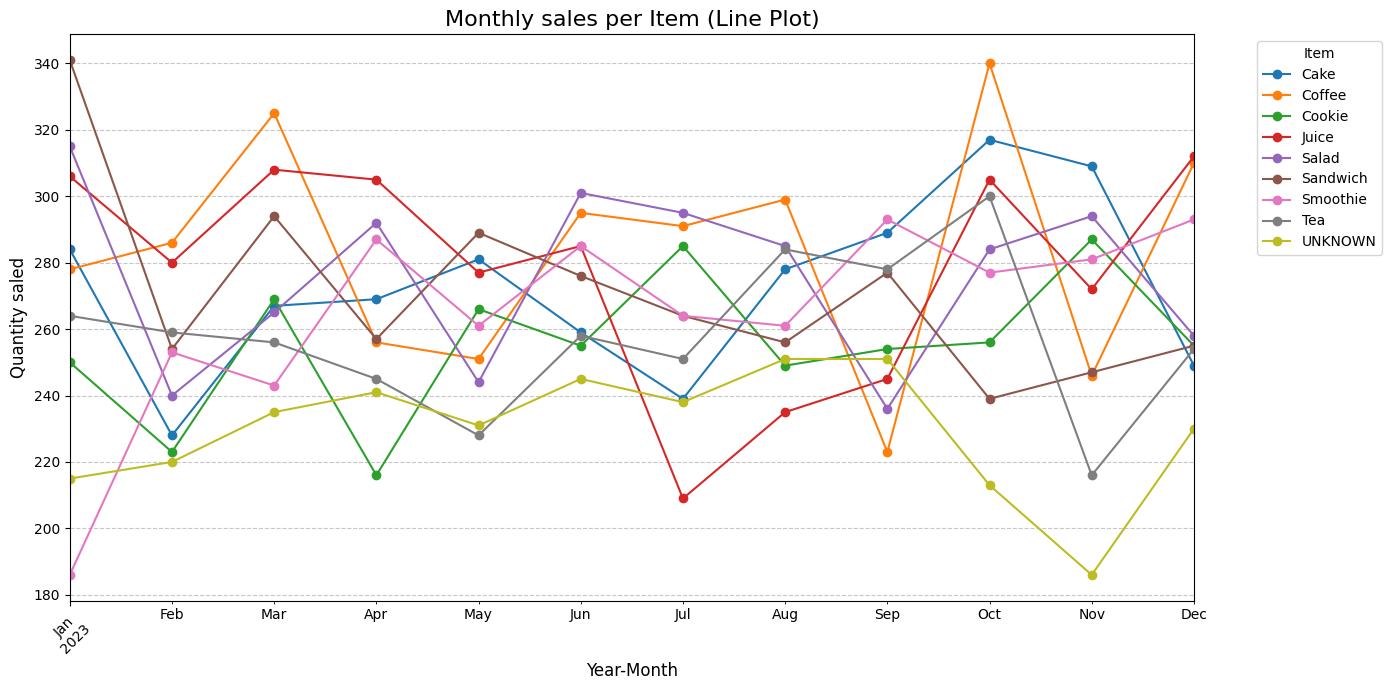

In [ ]:
item_sales = df.groupby(['Year-Month', 'Item'])['Quantity'].sum().unstack()

# Creare il grafico a linee
item_sales.plot(kind='line', figsize=(14, 7), marker='o')

# Personalizzare il grafico
plt.title('Monthly sales per Item (Line Plot)', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Quantity saled', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrare il grafico
plt.show()

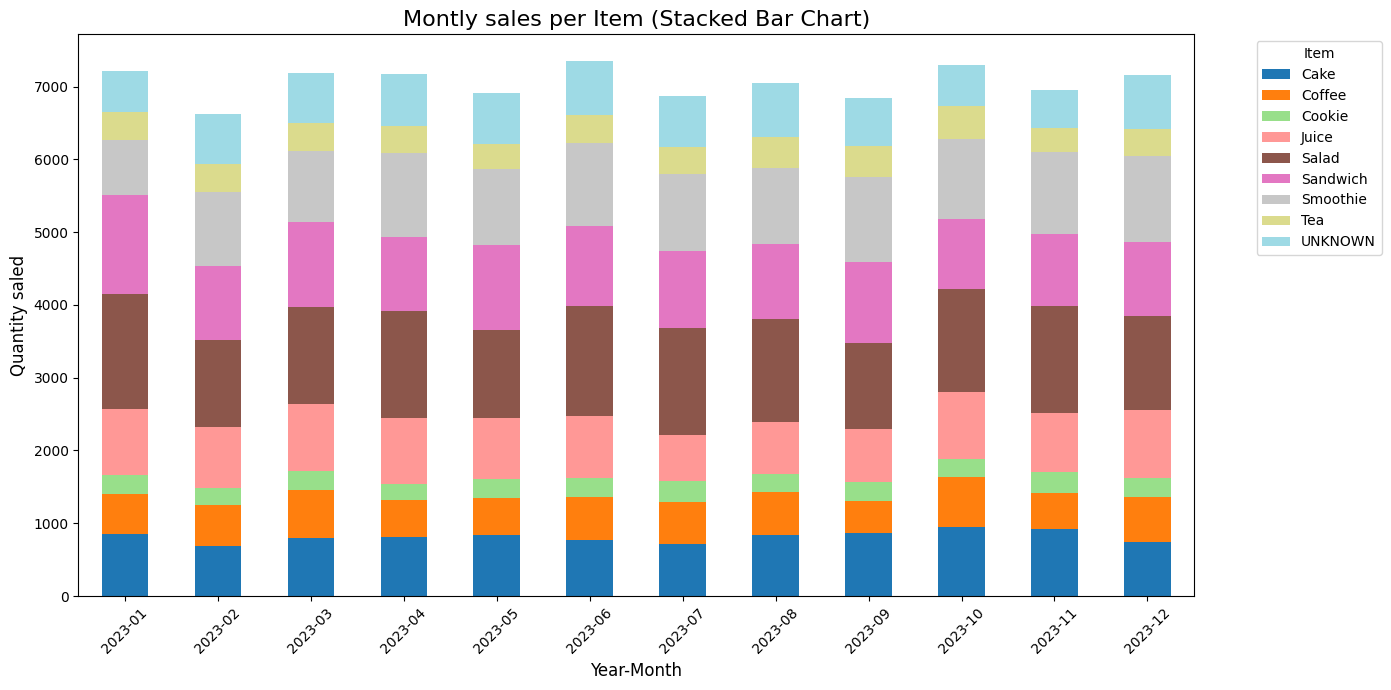

In [ ]:
# Bar plot
item_sales = df.groupby(['Year-Month', 'Item'])['Total Spent'].sum().unstack()
item_sales.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')

plt.title('Montly sales per Item (Stacked Bar Chart)', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Quantity saled', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
# new col 'Weekday'
df['Weekday'] = df['Transaction Date'].dt.day_name()

# new col 'Is_Weekend' to identify weekend days
df['Is_Weekend'] = df['Transaction Date'].dt.weekday.isin([5, 6])  # Sabato (5) e Domenica (6)

print(df[['Transaction Date', 'Weekday', 'Is_Weekend']].head())

  Transaction Date    Weekday  Is_Weekend
0       2023-09-08     Friday       False
1       2023-05-16    Tuesday       False
2       2023-07-19  Wednesday       False
3       2023-04-27   Thursday       False
4       2023-06-11     Sunday        True


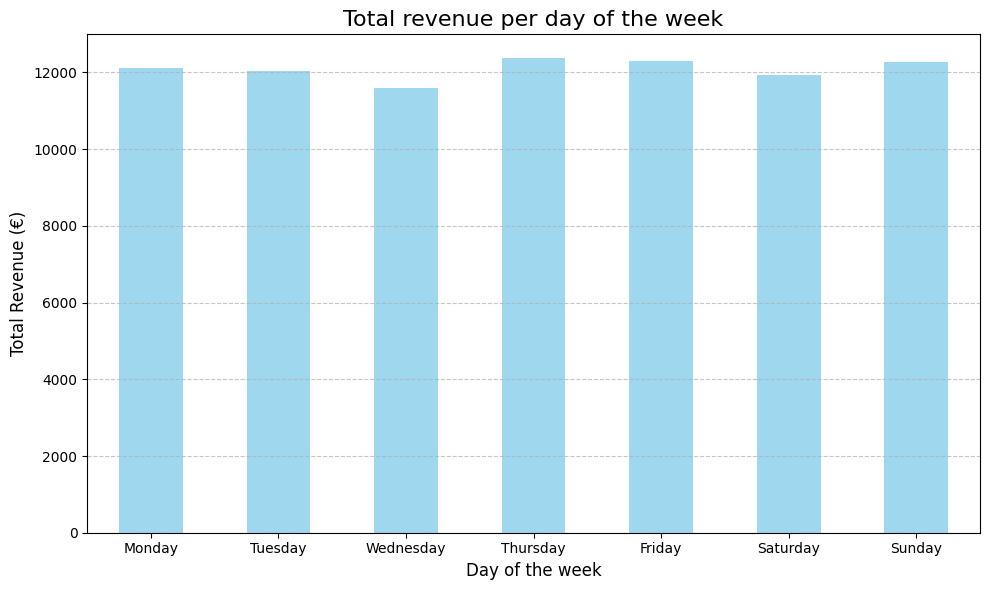

In [ ]:
weekday_sales = df.groupby('Weekday')['Total Spent'].sum()

ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(ordered_weekdays)

# Bar plot
plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar', color='skyblue', alpha=0.8)

plt.title('Total revenue per day of the week', fontsize=16)
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Total Revenue (€)', fontsize=12)
plt.xticks(rotation=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

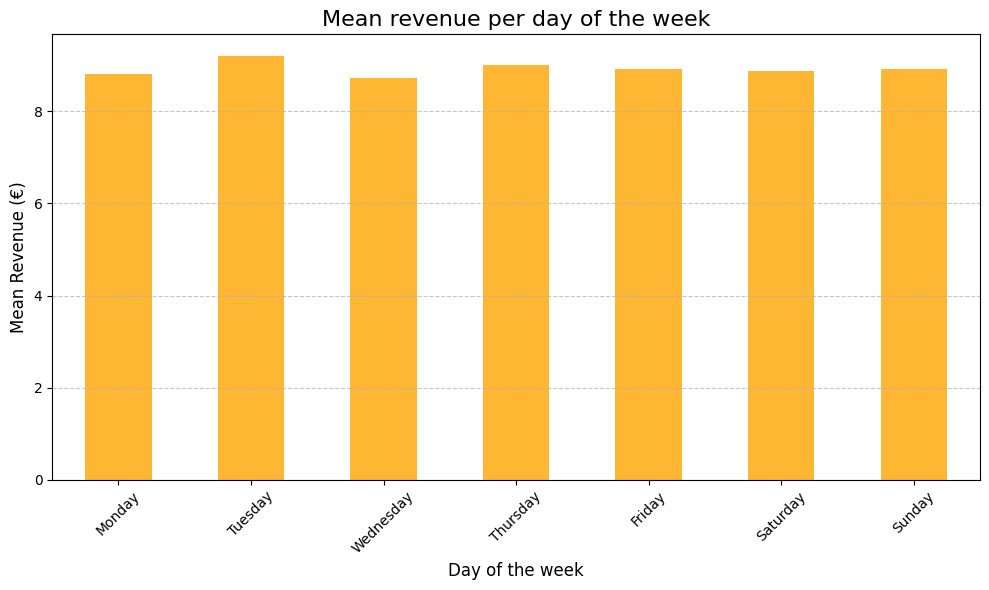

In [ ]:
weekday_avg_sales = df.groupby('Weekday')['Total Spent'].mean()

weekday_avg_sales = weekday_avg_sales.reindex(ordered_weekdays)

plt.figure(figsize=(10, 6))
weekday_avg_sales.plot(kind='bar', color='orange', alpha=0.8)

plt.title('Mean revenue per day of the week', fontsize=16)
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Mean Revenue (€)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()